<a href="https://colab.research.google.com/github/MathewBiddle/sandbox/blob/main/notebooks/CKAN_API_Query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Search [IOOS Data Catalog](https://data.ioos.us/) for CF standard names that contain `oxygen` and `sea_water`.

In [24]:
# For Google Colab, uncomment the lines below

import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["ckanapi", "geopandas"]


_colab_install_missing_deps(deps)

## Build CKAN API query base.

Uses https://github.com/ckan/ckanapi

In [3]:
from ckanapi import RemoteCKAN
ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

## What organizations are in the catalog?

Tell me what organizations are there.

In [4]:
orgs = ioos_catalog.action.organization_list()
print(orgs)

['aoos', 'caricoos', 'cdip', 'cencoos', 'comt', 'gcoos', 'glider-dac', 'glos', 'hf-radar-dac', 'ioos', 'maracoos', 'nanoos', 'neracoos', 'noaa-co-ops', 'noaa-ndbc', 'oceansites', 'pacioos', 'sccoos', 'secoora', 'unidata', 'usgs', 'us-navy']


## How many datasets are we searching across?

Grab all the datasets available.

In [5]:
#datasets = ioos_catalog.action.package_search(fq='+cf_standard_names:mass_concentration_of_oxygen_in_sea_water', rows=50)
datasets = ioos_catalog.action.package_search()
datasets['count']

43058

## Grab the most recent applicable CF standard names

Collect CF standard names that contain `oxygen` and `sea_water` from the CF standard name list.

In [6]:
import pandas as pd

url = "https://cfconventions.org/Data/cf-standard-names/current/src/cf-standard-name-table.xml"

df = pd.read_xml(url, xpath="entry")

std_names = df.loc[(df['id'].str.contains('oxygen') & df['id'].str.contains('sea_water'))]

std_names[['id','description']]

,id,description
469,depth_at_shallowest_local_minimum_in_vertical_...,Depth is the vertical distance below the surfa...
624,fractional_saturation_of_oxygen_in_sea_water,Fractional saturation is the ratio of some mea...
1357,mass_concentration_of_oxygen_in_sea_water,Mass concentration means mass per unit volume ...
1725,mole_concentration_of_dissolved_molecular_oxyg...,Mole concentration means number of moles per u...
1726,mole_concentration_of_dissolved_molecular_oxyg...,"""Mole concentration at saturation"" means the m..."
1727,mole_concentration_of_dissolved_molecular_oxyg...,Mole concentration means number of moles per u...
1825,mole_concentration_of_preformed_dissolved_mole...,"""Mole concentration"" means the number of moles..."
1996,moles_of_oxygen_per_unit_mass_in_sea_water,"moles_of_X_per_unit_mass_inY is also called ""m..."
3203,surface_molecular_oxygen_partial_pressure_diff...,"The surface called ""surface"" means the lower b..."
3700,temperature_of_sensor_for_oxygen_in_sea_water,Temperature_of_sensor_for_oxygen_in_sea_water ...


## Search across IOOS Data Catalog

Search IOOS Data Catalog for CF standard names that match those above.

In [7]:
from ckanapi import RemoteCKAN
import time
ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

df_out = pd.DataFrame()

for std_name in std_names['id']:

  print(std_name)

  fq = '+cf_standard_names:{}'.format(std_name)

  result_count = 0

  while True:
    datasets = ioos_catalog.action.package_search(fq=fq, rows=500)

    num_results = datasets['count']

    print(f"num_results: {num_results}, result_count: {result_count}")

    for dataset in datasets['results']:
        #print(dataset['title'])
        df = pd.DataFrame({'title': [dataset['title']],
                         'url': [dataset['resources'][0]['url']],
                         'org': [dataset['organization']['title']],
                         'std_name':std_name})

        df_out = pd.concat([df_out, df])

        result_count = result_count + 1

    time.sleep(1)

    if(result_count >= num_results):
        print(f"num_results: {num_results}, result_count: {result_count}")
        break

df_out

depth_at_shallowest_local_minimum_in_vertical_profile_of_mole_concentration_of_dissolved_molecular_oxygen_in_sea_water
num_results: 0, result_count: 0
num_results: 0, result_count: 0
fractional_saturation_of_oxygen_in_sea_water
num_results: 987, result_count: 0
num_results: 987, result_count: 500
num_results: 987, result_count: 1000
mass_concentration_of_oxygen_in_sea_water
num_results: 2735, result_count: 0
num_results: 2735, result_count: 500
num_results: 2735, result_count: 1000
num_results: 2735, result_count: 1500
num_results: 2735, result_count: 2000
num_results: 2735, result_count: 2500
num_results: 2735, result_count: 3000
mole_concentration_of_dissolved_molecular_oxygen_in_sea_water
num_results: 300, result_count: 0
num_results: 300, result_count: 300
mole_concentration_of_dissolved_molecular_oxygen_in_sea_water_at_saturation
num_results: 0, result_count: 0
num_results: 0, result_count: 0
mole_concentration_of_dissolved_molecular_oxygen_in_sea_water_at_shallowest_local_minimum

,title,url,org,std_name
0,St. Lucie Estuary - South Fork 2 (SLE-SF2),https://erddap.secoora.org/erddap/tabledap/st-...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,"Neuse River at Marker 15 (ModMon 70, AWS J8903...",https://erddap.secoora.org/erddap/tabledap/neu...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,Pamlico Sound at PS9 (ModMon),https://erddap.secoora.org/erddap/tabledap/pam...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,Indian River Lagoon - Jensen Beach (IRL-JB),https://erddap.secoora.org/erddap/tabledap/ind...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,Indian River Lagoon - Sebastian (IRL-SB),https://erddap.secoora.org/erddap/tabledap/ind...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
...,...,...,...,...
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water


## Do some summarizing of the responses

How many orgs have dissolved O2 data?

In [8]:
df_out.groupby(by='org').count()

,title,url,std_name
org,,,
CeNCOOS,2,2,2
GCOOS,2208,2208,2208
Glider DAC,2625,2625,2625
NERACOOS,28,28,28
PacIOOS,16,16,16
SECOORA,606,606,606


## Digging into the duplicates we have.

How many of those are unique? The search above looked for all cf standard names for dissolved Oxygen. We might have some duplicate dataset returns, which means the same dataset might have multiple oxygen variables. So, let's filter down just to the unique datasets to query for data.

In [9]:
df_group = df_out.groupby(by='url').count()

df_group

,title,org,std_name
url,,,
http://www.neracoos.org/erddap/tabledap/A01_optode_all,3,3,3
http://www.neracoos.org/erddap/tabledap/GRBGBWQ_NERRS,4,4,4
http://www.neracoos.org/erddap/tabledap/GRBLRWQ_NERRS,4,4,4
http://www.neracoos.org/erddap/tabledap/LOBO_CSV_65,1,1,1
http://www.neracoos.org/erddap/tabledap/URI_168-MV_BottomSonde,16,16,16
...,...,...,...
https://gliders.ioos.us/erddap/tabledap/unit_648-20230324T1507,2,2,2
https://gliders.ioos.us/erddap/tabledap/uvi_01-20230921T1324,6,6,6
https://gliders.ioos.us/erddap/tabledap/uvi_01-20240809T1334,2,2,2


## Drop duplicate records

We identify duplicates by looking at the URL, which should be unique for each dataset.

In [10]:
df_out_nodups = df_out.drop_duplicates(subset=['url'],keep='last')

df_out_nodups

,title,url,org,std_name
0,Neuse River near the south shore (ModMon 96),https://erddap.secoora.org/erddap/tabledap/neu...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,"Great Bay,NH. Lamprey River WQ station",http://www.neracoos.org/erddap/tabledap/GRBLRW...,NERACOOS,fractional_saturation_of_oxygen_in_sea_water
0,"Great Bay,NH. Great Bay WQ station",http://www.neracoos.org/erddap/tabledap/GRBGBW...,NERACOOS,fractional_saturation_of_oxygen_in_sea_water
0,um_242-20221205T1648-delayed,https://gliders.ioos.us/erddap/tabledap/um_242...,Glider DAC,fractional_saturation_of_oxygen_in_sea_water
0,ru30-20221011T1527-delayed,https://gliders.ioos.us/erddap/tabledap/ru30-2...,Glider DAC,fractional_saturation_of_oxygen_in_sea_water
...,...,...,...,...
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water


## How many endpoints are not ERDDAP?

Just to see what endpoints we're working with, let's show endpoints that aren't ERDDAP.

In [11]:
df_out_nodups.loc[~df_out_nodups['url'].str.contains('erddap')]

,title,url,org,std_name


## Drop the Glider DAC data

Glider DAC is already making it to NCEI, so we can drop those entries.

In [12]:
df_out_nodups_no_glider = df_out_nodups.loc[~df_out_nodups['org'].str.contains('Glider DAC')]
df_out_nodups_no_glider

,title,url,org,std_name
0,Neuse River near the south shore (ModMon 96),https://erddap.secoora.org/erddap/tabledap/neu...,SECOORA,fractional_saturation_of_oxygen_in_sea_water
0,"Great Bay,NH. Lamprey River WQ station",http://www.neracoos.org/erddap/tabledap/GRBLRW...,NERACOOS,fractional_saturation_of_oxygen_in_sea_water
0,"Great Bay,NH. Great Bay WQ station",http://www.neracoos.org/erddap/tabledap/GRBGBW...,NERACOOS,fractional_saturation_of_oxygen_in_sea_water
0,"WACCASASSA RIVER NR GULF HAMMOCK, FLA. (USGS 0...",https://erddap.secoora.org/erddap/tabledap/gov...,SECOORA,mass_concentration_of_oxygen_in_sea_water
0,"LITTLE BACK RIVER AT HOG ISLAND, NEAR SAVANNAH...",https://erddap.secoora.org/erddap/tabledap/gov...,SECOORA,mass_concentration_of_oxygen_in_sea_water
...,...,...,...,...
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water
0,"Walton-Smith CTD, WS22215, WS22215_2022_08_Wea...",https://gcoos5.geos.tamu.edu/erddap/tabledap/W...,GCOOS,volume_fraction_of_oxygen_in_sea_water


## What's the remaining distribution?

This is the distribution of unique datasets found in the IOOS Data Catalog which have a CF Standard Name that contains the work `oxygen` and `sea_water`. We've dropped out the Glider DAC datasets as, theoretically, those are in NCEI already.

In [13]:
df_out_nodups_no_glider.groupby(by='org').count()

,title,url,std_name
org,,,
CeNCOOS,2,2,2
GCOOS,378,378,378
NERACOOS,5,5,5
PacIOOS,2,2,2
SECOORA,35,35,35


Let's print out the response as a csv to share.

In [14]:
# print(df_out_nodups_no_glider.to_csv(index=False))

Let's rip through all of the datasets, grab the data as a table (including units) and make a monster dictionary. This takes a bit.

In [15]:
df_out_final = {}

for index,row in df_out_nodups_no_glider.iterrows():
    #print(row)
    df_out_final['{}'.format(row['title'])] = pd.read_csv('{}.csv'.format(row['url']), low_memory=False)

In [16]:
df_out_final.keys()

dict_keys(['Neuse River near the south shore (ModMon 96)', 'Great Bay,NH. Lamprey River WQ station', 'Great Bay,NH. Great Bay WQ station', 'WACCASASSA RIVER NR GULF HAMMOCK, FLA. (USGS 02313700)', 'LITTLE BACK RIVER AT HOG ISLAND, NEAR SAVANNAH, GA (USGS 021989793)', 'CRABTREE SWAMP AT CONWAY, SC (USGS 02110701)', 'Pamlico Sound at PS9 (ModMon)', 'St. Lucie Estuary - South Fork (SLE-SF)', 'Indian River Lagoon - Link Port (IRL-LP)', 'Indian River Lagoon - Sebastian (IRL-SB)', 'Indian River Lagoon - Jensen Beach (IRL-JB)', 'MIDDLE RIVER AT FISH HOLE AT PORT WENTWORTH, GA (USGS 02198955)', 'Indian River Lagoon - Vero Beach (IRL-VB)', 'Sanibel Dock', 'ST JOHNS R DAMES POINT BRIDGE AT JACKSONVILLE, FL (USGS 302309081333001)', 'New Pass Bridge', 'LAKE MATTAMUSKEET E OF NC HWY 94 NR FAIRFIELD, NC (USGS 0208458893)', 'COOPER R AT FILBIN CREEK AT NORTH CHARLESTON, SC (USGS 021720677)', 'Neuse River South River (ModMon 165)', 'Neuse River near the north shore (ModMon 95)', 'Pamlico Sound at PS1 

In [17]:
df_out_final["\"Deepwater CTD - pe972218.ctd.nc - 29.25N, -87.89W - 1997-03-21\""]

,profile,time,latitude,longitude,numberOfLevel,depth,temperature,salinity,oxygen,nitrite,...,phosphate,silicate,salinity2,qualityFlag,instrument,instrument1,instrument2,instrument3,instrument4,instrument5
0,NaN,UTC,degrees_north,degrees_east,NaN,m,degree_C,PSU,milliliters per liter,micromols,...,micromols,micromols,PSU,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1968-01-20T03:14:07Z,29.24720001220703,87.88890075683594,351.0,7.0,20.822999954223633,35.321998596191406,4.590000152587891,0.0,...,0.019999999552965164,1.3300000429153442,36.10300064086914,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1968-01-20T03:14:07Z,29.24720001220703,87.88890075683594,351.0,8.0,20.832000732421875,35.332000732421875,4.619999885559082,0.0,...,0.009999999776482582,1.1799999475479126,36.09299850463867,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1968-01-20T03:14:07Z,29.24720001220703,87.88890075683594,351.0,9.0,20.836999893188477,35.33599853515625,4.630000114440918,0.0,...,0.0,1.1299999952316284,36.09400177001953,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1968-01-20T03:14:07Z,29.24720001220703,87.88890075683594,351.0,10.0,20.83799934387207,35.3380012512207,4.630000114440918,0.0,...,0.009999999776482582,1.0499999523162842,36.09600067138672,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,NaN,1968-01-20T03:14:07Z,29.24720001220703,87.88890075683594,351.0,353.0,10.270999908447266,35.23400115966797,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
348,NaN,1968-01-20T03:14:07Z,29.24720001220703,87.88890075683594,351.0,354.0,10.206999778747559,35.2239990234375,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
349,NaN,1968-01-20T03:14:07Z,29.24720001220703,87.88890075683594,351.0,355.0,10.199999809265137,35.22200012207031,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
350,NaN,1968-01-20T03:14:07Z,29.24720001220703,87.88890075683594,351.0,356.0,10.194999694824219,35.22100067138672,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_out_final["\"Deepwater CTD - pe972218.ctd.nc - 29.25N, -87.89W - 1997-03-21\""][['latitude','longitude']]

,latitude,longitude
0,degrees_north,degrees_east
1,29.24720001220703,87.88890075683594
2,29.24720001220703,87.88890075683594
3,29.24720001220703,87.88890075683594
4,29.24720001220703,87.88890075683594
...,...,...
347,29.24720001220703,87.88890075683594
348,29.24720001220703,87.88890075683594
349,29.24720001220703,87.88890075683594
350,29.24720001220703,87.88890075683594


## Clean up the coordinates to make a map

In [19]:
df_coords = pd.DataFrame(columns=['latitude','longitude'])

for key in df_out_final.keys():
    df_coords = pd.concat([df_coords, df_out_final[key][['latitude','longitude']]])

# remove the units rows, drop all duplicates, and return float dataFrame
df_coords_clean = df_coords[df_coords.latitude != 'degrees_north'].drop_duplicates(ignore_index=True).astype(float)

df_coords_clean

,latitude,longitude
0,34.969100,-76.907100
1,43.080000,-70.934400
2,43.072200,-70.869400
3,29.204134,-82.769001
4,32.136667,-81.121944
...,...,...
467,26.187333,-82.211333
468,25.352167,-81.655333
469,26.343833,-82.041167
470,25.351500,-81.334500


## Create a function for mapping

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt

def make_map(df):
    # initialize an axis
    fig, ax = plt.subplots(figsize=(8,6))# plot map on axis
    countries = gpd.read_file(  
         gpd.datasets.get_path("naturalearth_lowres"))

    countries[countries["name"] == "United States of America"].plot(color="lightgrey",
                                                 ax=ax)

    # plot points
    df.plot(x="longitude", y="latitude", 
                     kind="scatter",
                     ax=ax)# add grid

    ax.grid(visible=True, alpha=0.5)

    return ax

## Make a map with the coordinates

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

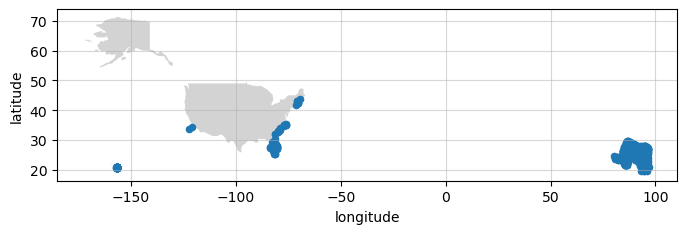

In [21]:
make_map(df_coords_clean)

## Something looks fishy with the coordinates!

longitude values should be `degrees_east` (following CF conventions), but it looks like some are `degrees_west`. The next steps finds those `degrees_west` values and does a conversion to flip from `degrees_west` to `degrees_east`. Check to see what the map looks like now.

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

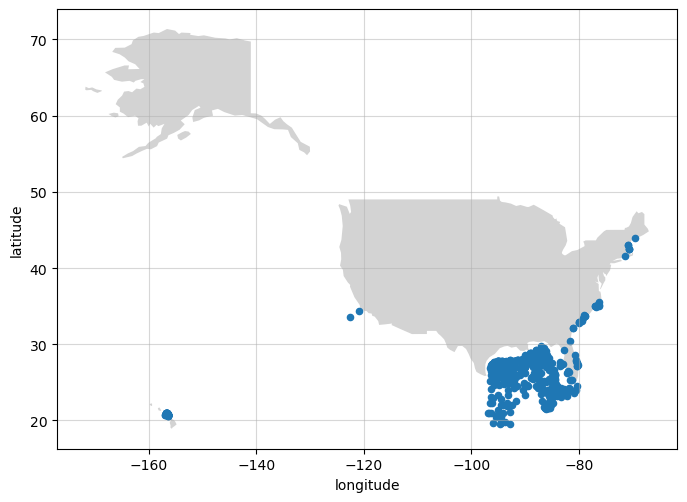

In [22]:
import numpy as np

df_coords_clean.longitude = np.where( 
    df_coords_clean.longitude > 0, 
    df_coords_clean.longitude * -1,
    df_coords_clean.longitude
)

make_map(df_coords_clean)

## That looks better! 

Now let's explore some of those points.

In [23]:
gdf = gpd.GeoDataFrame(
    df_coords_clean, geometry=gpd.points_from_xy(df_coords_clean.longitude, df_coords_clean.latitude), crs="EPSG:4326"
)

gdf.explore()